In [1]:
# graphs and tablesd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NN's tools
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

# to separate the data
from sklearn.model_selection import train_test_split

## 1. Import Data

In [2]:
train = pd.read_csv("data/train.csv",dtype=np.float32)
test = pd.read_csv("data/test.csv", dtype=np.float32)

## 2. Prepare Data

In [3]:
targets_numpy = train.label.values
features_numpy = train.iloc[:,train.columns!="label"].values/255 # normalization 

features_train, features_test, targets_train, targets_test = train_test_split(features_numpy, targets_numpy, test_size=0.2, random_state=42)

# create feature and targets tensor for train set
FeaturesTrain = torch.from_numpy(features_train)
TargetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)


FeaturesTest = torch.from_numpy(features_test)
TargetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

#batch size, epoch and iterations
batch_size = 100
num_iterations = 10000
num_epochs = num_iterations/(len(features_train)/batch_size)
num_epochs = int(num_epochs)

#pytorch train and test set
train = torch.utils.data.TensorDataset(FeaturesTrain, TargetsTrain)
test = torch.utils.data.TensorDataset(FeaturesTest, TargetsTest)

#dataloader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [4]:
# Create CNN Model

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max Pooling 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max Pooling 2 
        out = self.maxpool2(out)
        
        # flatten
        out = out.view(out.size(0), -1)

        # Linear function
        out = self.fc1(out)
        
        return out
    
# Model
model = CNNModel()

# Loss Funciton 
error = nn.CrossEntropyLoss()

# Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## 3. Train Model

In [5]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(100,1,28,28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if count % 1000 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 1000  Loss: 0.046640802174806595  Accuracy: 97.61904907226562 %
Iteration: 2000  Loss: 0.01922767050564289  Accuracy: 98.20237731933594 %
Iteration: 3000  Loss: 0.029458055272698402  Accuracy: 98.32142639160156 %
Iteration: 4000  Loss: 0.004333339631557465  Accuracy: 98.55952453613281 %
Iteration: 5000  Loss: 0.0051883612759411335  Accuracy: 98.48809814453125 %
Iteration: 6000  Loss: 0.021358836442232132  Accuracy: 98.36904907226562 %
Iteration: 7000  Loss: 0.01151804905384779  Accuracy: 98.53571319580078 %
Iteration: 8000  Loss: 0.2521005868911743  Accuracy: 98.19047546386719 %
Iteration: 9000  Loss: 0.0031241043470799923  Accuracy: 98.76190185546875 %


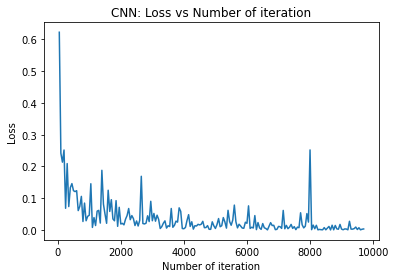

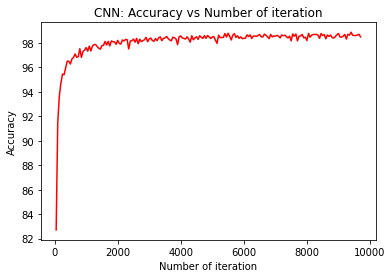

In [6]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [7]:
# saving weights
PATH = './digit_net.pth'
torch.save(model.state_dict(), PATH)

In [8]:
# prepeare test data for predicting

test = pd.read_csv("data/test.csv", dtype=np.float32)

features_numpy = test.iloc[:, test.columns!="label"].values/255 # normalization 
targets_numpy = np.zeros(28000) # dummy variables for the model to work with

FeaturesTest = torch.from_numpy(features_numpy)
TargetTest = torch.from_numpy(targets_numpy)

test = torch.utils.data.TensorDataset(FeaturesTest, TargetTest)

testloader = DataLoader(test, batch_size=batch_size, shuffle=False)

## 4. Predict

In [9]:
net = CNNModel()
net.load_state_dict(torch.load('./digit_net.pth'))

<All keys matched successfully>

In [10]:
# make a submission
submission = []
for images, i in testloader:

    test = Variable(images.view(100,1,28,28))
    outputs = model(test)
    predicted = torch.max(outputs.data, 1)[1]
    submission.append(predicted.numpy()) 

In [11]:
predictions = []

data = np.asarray(submission)
for row in data:
    for index in row:
        predictions.append(index)
        
submission = np.array(predictions)

In [12]:
my_submission = pd.read_csv('data/sample_submission.csv')

In [13]:
my_submission['Label'] = submission

In [14]:
my_submission = my_submission.set_index('ImageId')
my_submission.to_csv('submission.csv')

## Predict: 0.98460